# 목차
[Exp-11]_CV4_GAN_Project

STEP 1. 작업환경 구성하기

STEP 2. 데이터셋 구성하기

STEP 3. 생성자 모델 구현하기

STEP 4. 판별자 모델 구현하기

STEP 5. 손실함수와 최적화 함수 구현하기

STEP 6. 훈련과정 상세 기능 구현하기

STEP 7. 학습 과정 진행하기

STEP 8. (optional) GAN 훈련 과정 개선하기


# STEP 1. 작업환경 구성하기

In [2]:
import tensorflow 
import imageio

print(tensorflow.__version__)
print(imageio.__version__)

2.8.2
2.9.0


In [3]:
import tensorflow as tf

In [4]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.8.2


# STEP 2. 데이터셋 구성하기

In [5]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 2s 0us/step


(50000, 32, 32, 3)

In [6]:
# CIFAR10

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [7]:
# 각 픽셀을 -1, 1로 정규화

train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [8]:
train_x.shape

(50000, 32, 32, 3)

## 컬러 이미지 출력하는 방법 2가지
* float = 0~1
* int = 0~255

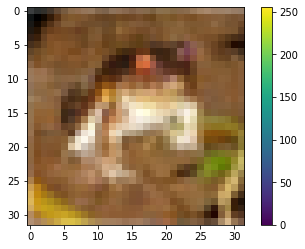

In [9]:
train_rx = (train_x * 127.5) + 127.5
train_rx = train_rx.astype(int)
plt.imshow(train_rx[0])
plt.colorbar()
plt.show()


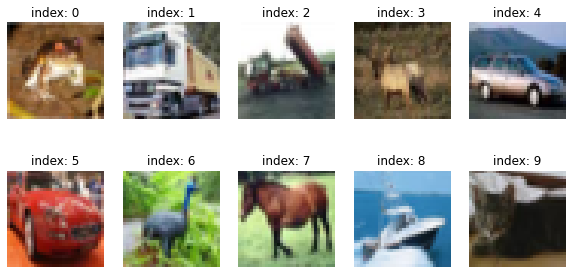

In [10]:
#plt.subplot(row, col, index)
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_rx[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [11]:
#BUFFER_SIZE은 전체 데이터를 섞기 위해 60,000으로 설정
#BATCH_SIZE는 모델이 한 번에 학습할 데이터의 양
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [12]:
# from_tensor_slices(): 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#STEP 3. 생성자 모델 구현하기

In [13]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [14]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

In [15]:
# 랜덤 노이즈 생성
noise = tf.random.normal([1, 100])

In [16]:
# 랜덤 이미지와 생성자 출력 규격 확인
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

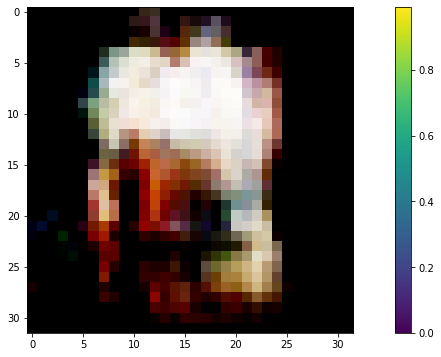

In [35]:
plt.imshow(generated_image[0, :, :, :])
plt.colorbar()
plt.show()

#STEP 4. 판별자 모델 구현하기

In [18]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [19]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [20]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00184234]], dtype=float32)>

#STEP 5. 손실함수와 최적화 함수 구현하기

In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
# generator_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [23]:
# discriminator_loss

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [24]:
# discriminator accuracy

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [25]:
# optimizer

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [26]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

#STEP 6. 훈련과정 상세 기능 구현하기

In [27]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

현재 이미지 범위 -1 ~ 1 

원하는 이미지 범위 0~1

float 0 ~ 1
int 0 ~ 255

0 ~ 255 > -1 ~ 1정규화(-127.5/127.5) > -127.5 ~ 127.5 :0 ~ 255(원래대로 )> +1 /2

In [28]:
# .png 확장자 
# 변수 표현식


def generate_and_save_images(model, epoch, it, sample_seeds):


    predictions = model(sample_seeds, training=False)
    predictions_r = (predictions +1) /2


    fig = plt.figure(figsize=(15, 15))
    for i in range(predictions_r.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions_r[i, :, :, :])
        plt.axis('off')
   
    plt.savefig('/content/drive/MyDrive/Aiffel_data/generated_samples2/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))
    plt.show()

In [29]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/Aiffel_data/Exp_Stage/Exp11_CV4_GAN/Project/training_history/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

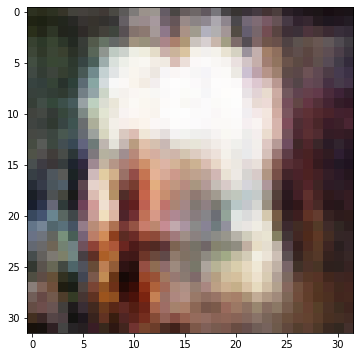

In [30]:
# 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.

checkpoint_dir = '/content/drive/MyDrive/Aiffel_data/Exp_Stage/Exp11_CV4_GAN/Project/training_checkpoints/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

#STEP 7. 학습 과정 진행하기

In [31]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
save_every = 10
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

In [ ]:
# gif 시각화
anim_file = '/content/drive/MyDrive/Aiffel_data/choi_2.gif'


# /content/drive/MyDrive/Aiffel_data/Exp_Stage/Exp11_CV4_GAN/Project/generat/ed_samples
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/Aiffel_data/generated_samples3/sample*.png')
    filenames = sorted(filenames)
    print(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

#STEP 8. (optional) GAN 훈련 과정 개선하기

In [32]:
save_every = 10
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

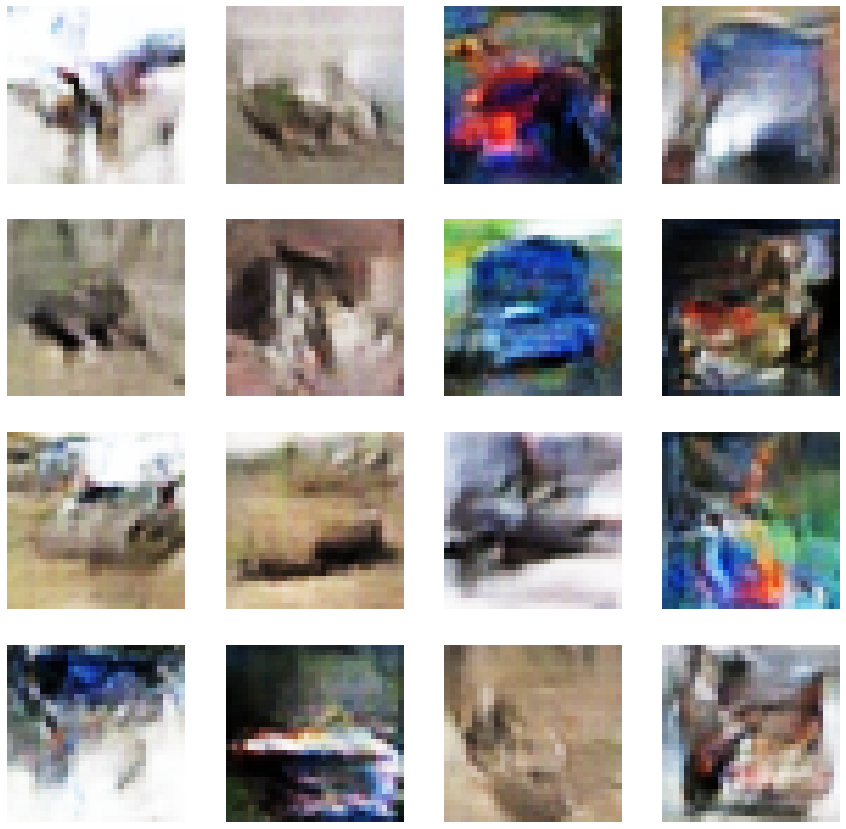

Time for training : 6995 sec


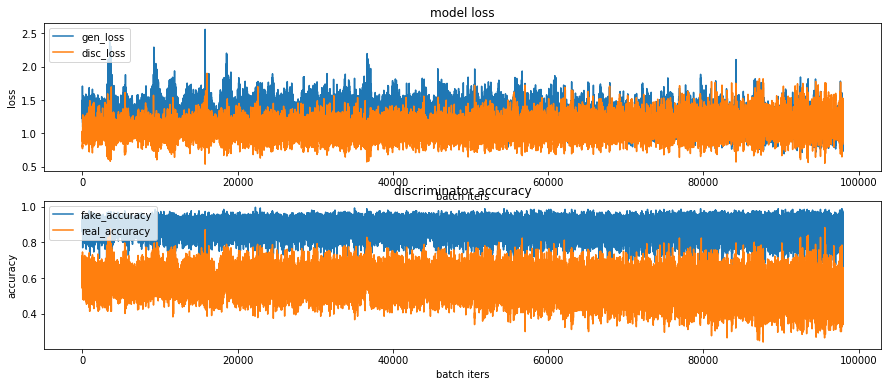

CPU times: user 1h 56min 36s, sys: 2min 43s, total: 1h 59min 19s
Wall time: 1h 56min 40s


In [33]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [34]:
# gif 시각화
anim_file = '/content/drive/MyDrive/Aiffel_data/choi_1.gif'


# /content/drive/MyDrive/Aiffel_data/Exp_Stage/Exp11_CV4_GAN/Project/generat/ed_samples
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/Aiffel_data/generated_samples2/sample*.png')
    filenames = sorted(filenames)
    print(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


['/content/drive/MyDrive/Aiffel_data/generated_samples2/sample_epoch_0001_iter_001.png', '/content/drive/MyDrive/Aiffel_data/generated_samples2/sample_epoch_0001_iter_051.png', '/content/drive/MyDrive/Aiffel_data/generated_samples2/sample_epoch_0001_iter_101.png', '/content/drive/MyDrive/Aiffel_data/generated_samples2/sample_epoch_0001_iter_151.png', '/content/drive/MyDrive/Aiffel_data/generated_samples2/sample_epoch_0002_iter_001.png', '/content/drive/MyDrive/Aiffel_data/generated_samples2/sample_epoch_0002_iter_051.png', '/content/drive/MyDrive/Aiffel_data/generated_samples2/sample_epoch_0002_iter_101.png', '/content/drive/MyDrive/Aiffel_data/generated_samples2/sample_epoch_0002_iter_151.png', '/content/drive/MyDrive/Aiffel_data/generated_samples2/sample_epoch_0003_iter_001.png', '/content/drive/MyDrive/Aiffel_data/generated_samples2/sample_epoch_0003_iter_051.png', '/content/drive/MyDrive/Aiffel_data/generated_samples2/sample_epoch_0003_iter_101.png', '/content/drive/MyDrive/Aiffel_

epoch 50, epoch 500

1. gif:
500 epoch 윤곽선이 더욱 두껍고 선명하게 그려졌다. 

2. 그래프 :
gen loss와 dis loss가 비교적 loss값이 안정되었다. 
반면 accuracy는 발산했다.

3. 이미지 :
50일때보다는 그래도 500일때 더욱 cifar10의 이미지와 유사하게 출력되었다.

회고 작성법

# 회고

### - 이번 프로젝트에서 **어려웠던 점**.

에폭을 진행할수록 학습시간이 더 오래 걸려서 어려웠다. 

### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
컬러 표현 : float 0 ~ 1 int 0 ~ 255

현재 이미지 범위 -1 ~ 1 >>> 원하는 이미지 범위 0~1

0 ~ 255 > -1 ~ 1정규화(-127.5/127.5) > -127.5 ~ 127.5 :0 ~ 255(원래대로 )> +1 /2

### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
epoch 수를 300으로 증가 시켜서  50 epoch 대와 비교해 본다.

>#### **루브릭평가 지표**
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1|  GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다. |오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.|
>|2|생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.| gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.|
>|3|추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.|모델구조 변경 혹은 학습과정 개선 아이디어를 추가적으로 적용해보았고, 적용 전과 비교하였을 때의 내용을 표와 같은 시각적 자료로 작성하였다.|



### - **자기 다짐**
* GAN 개념 다시 한번 짚어보기 


